In [18]:
import numpy as np
import matplotlib.pyplot as plt
from dynamicalsystems.lorenz63 import Lorenz63Model
from DAmethod.particle_filter import ParticleFilter
%matplotlib inline

In [26]:
Nparticles = 500
period_assim = 1
assimilation_steps = 100

In [27]:
# Properties of the model

dt = 0.02
Lorenz63Model.dt = dt
H = np.atleast_2d([[1, 0, 0], [0, 1, 0]])
sigobs = 5
R = sigobs * np.atleast_2d([[1, 0], [0, 1]])

In [28]:

PF = ParticleFilter(state_dimension=3, Nparticles=Nparticles, R=R)
PF.H = H
PF.set_forwardmodel(lambda x: Lorenz63Model.integrate(
    0, x, period_assim)[1][:, -1])
truth = Lorenz63Model()
truth.set_initial_state(-5000 * dt, np.array([0, 1, 0]))
truth.forward(5000)  # Burn-in period
def generate_observations(i):
    truth.forward(period_assim)
    y = truth.state_vector[:, -1] + np.random.randn(1) * sigobs
    return truth.t[-1], y
PF.generate_particles(
    prior_mean=truth.state_vector[:, -1] + np.random.randn(3) * sigobs,
    prior_cov=sigobs * np.array([[1, 0, 0], [0, 1, 0], [0, 0, 1]]),
)

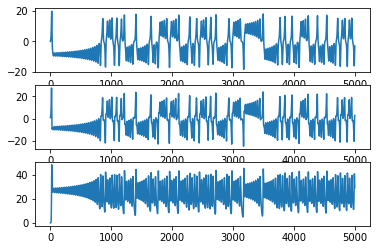

In [29]:
truth = Lorenz63Model()
truth.set_initial_state(-5000 * dt, np.array([0, 1, 0]))
truth.forward(5000)  # Burn-in period
def generate_observations(i):
    truth.forward(period_assim)
    y = truth.state_vector[:, -1] + np.random.randn(1) * sigobs
    return truth.t[-1], y
PF.generate_particles(
    prior_mean=truth.state_vector[:, -1] + np.random.randn(3) * sigobs,
    prior_cov=sigobs * np.array([[1, 0, 0], [0, 1, 0], [0, 0, 1]]),
)
for i, traj in enumerate(truth.state_vector, 1):
    plt.subplot(3, 1, i)
    plt.plot(traj)


In [30]:
dPF = PF.run(assimilation_steps, generate_observations,
             full_obs=True, ESS_lim=None)

Iter ESS                        RMS
0    324.09                  505.41
1    125.19                  607.74 Resampling
2    391.80                  328.57
3    168.80                  231.88 Resampling
4    431.39                  326.60
5    383.60                  242.50
6    134.95                  876.88 Resampling
7    5.59                    163.69 Resampling
8    490.17                  473.96
9    138.15                  354.16 Resampling
10   426.81                  992.13
11   352.75                  768.70
12   334.27                 1013.35
13   121.02                  985.62 Resampling
14   318.78                 3392.28
15   317.66                 1614.00
16   317.15                 2052.04
17   317.24                  692.69
18   317.43                  565.86
19   318.00                  499.19
20   317.77                  664.06
21   321.98                  477.12
22   46.75                   339.45 Resampling
23   174.08                  488.62 Resampling
24   499.03 

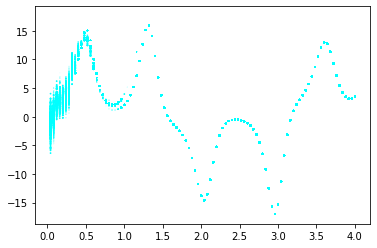

In [31]:

est_ = np.array(dPF["estimates"])[:, 0, :]
obs_ = np.array(dPF["observations"])[:, 0]
wei_ = np.array(dPF["weights"])
for i in range(assimilation_steps):
    plt.scatter(
        period_assim * (i + 1) * np.ones(Nparticles) * dt,
        np.asarray(dPF["particles"])[i, 0, :],
        marker="o",
        c="cyan",
        s=300 * wei_[i, :],
    )
v_ = [
    PF.weighted_moments(
        np.array(dPF["particles"])[i, :, :],
        np.array(dPF["weights"])[i, :],
    )[1]
    for i in range(assimilation_steps)
]

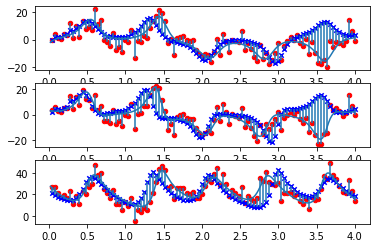

In [32]:
est_ = np.array(dPF["estimates"])[:, 0, :]
obs_ = np.array(dPF["observations"])
for i in range(3):
    plt.subplot(3, 1, i + 1)
    plt.plot(truth.t[5001:], truth.state_vector[i, 5001:])
    plt.scatter(dPF["time"], obs_[:, i], marker="o", c="red", s=20)
    plt.scatter(dPF["time"], est_[:, i], marker="x", color="blue", s=20)
    plt.vlines(dPF["time"], est_[:, i], obs_[:, i])
plt.show()